# LangGraph - Eine Einführung

Bis jetzt haben wir uns mit einem einzigen Agenten zufrieden gegeben. Aber wir können die Power der Agenten multiplizieren, wenn wir uns ein Agentensystem bauen!
Stell dir vor, du hast ein System, in dem für jede Aufgabe ein spezialisierter Agent zuständig ist. Komplexe Aufgaben werden z.B. durch einen Planer-Agent in Teilaufgaben heruntergebrochen und auf andere spezialisierte Agenten verteilt. Ein Koordinator kümmert sich um die Zusammenarbeit und trägt die Einzelergebnisse zusammen.

Das ist meines Erachtens die Zukunft. Stand heute Mitte 2024 gibt es diese Systeme schon, wenn auch nicht immer perfekt funktionierend. Aber die Entwicklung geht rasant voran und ich bin überzeugt, dass wir bald sehr gute Agentensysteme haben werden.

Aber so ein System ist komplex und es wäre sicher nicht sinnvoll das alles selber programmieren zu wollen. Deswegen möchten wir LangGraph kennenlernen und nutzen.

## Was ist LangGraph?

Laut der Beschreibung von den LangGraph-Machern selbst: 
> "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. "

Also handelt es sich um eine Bibliothek mit der wir Multi-Agenten Systeme (Agent Swarm) und Workflows bauen können! Mehr Details hier: https://langchain-ai.github.io/langgraph/

Was ist der Unterschied zu anderen Agenten-Frameworks wie AutoGen und Co.? LangGraph ist viel mehr Low-Level, d.h. man hat wesentlich mehr Kontrolle darüber, was und wie ausgeführt wird. Die anderen Frameworks hingegen verstecken die Logik. Oft definiert man dort, welche Agenten es gibt und welche Rollen sie haben. Die Art und Weise, wie sie interagieren etc. ist praktisch eine Blackbox.
Nachteil: LangGraph ist schwerer zu lernen.

Wir werden auch gleich sehen, dass die Programmierung eines Agentensystems auf Basis von LangGraph viel mit der Definition eines Workflowsystems zu tun hat.
Das Prinzip ist, dass KI (LLM ) dazu verwendet wird Entscheidungen zu treffen und Aktionen auszuführen, basierend auf dem Kontext.

Ein paar Zeilen Code sagen mehr als tausend Worte (berühmtes Zitat von S. Grünheit)... 

Wir wollen erstmal LangGraph ohne KI mal anschauen... einfach um das Gefühl zu bekommen, wie es tickt... Aber erstmal müssen wir LangGraph installieren.

In [63]:
!pip install langgraph langchain_openai


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


Jetzt bauen wir uns einen kleinen Graph. Dieser Graph macht zwar nichts besonders sinnvolles, aber er zeigt die Grundstruktur!

In [64]:
from langgraph.graph import MessageGraph, START, END
from langchain_core.messages import HumanMessage

# Wir erstellen einen MessageGraph. Das ist ein Graph, dessen "State" aus Messages besteht
graph = MessageGraph()

def modify_message(input: list[HumanMessage]):
    input[-1].content = input[-1].content + " - wurde geändert"
    return input

# Wir fügen zwei Nodes hinzu, die die Nachrichten verändern
graph.add_node("Node A", modify_message)
graph.add_node("Node B", modify_message)
graph.add_node("Node C", modify_message)

graph.add_edge(START, "Node A")
graph.add_edge("Node A", "Node B")
graph.add_edge("Node A", "Node C")

graph.add_edge("Node B", END)
graph.add_edge("Node C", END)

runnable = graph.compile()

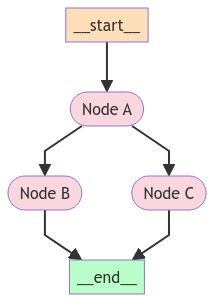

In [65]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [66]:
runnable.invoke([HumanMessage("Hallo Welt!")])

[HumanMessage(content='Hallo Welt! - wurde geändert - wurde geändert - wurde geändert', id='2c804cb0-e7d2-44f0-8d8e-d17491976f19')]

## Die Grundbausteine

LangGraph kennt drei wesentliche Grundbausteine: _Node_, _Edge_ und _State_. Schauen wir uns diese mal genauer an.

### Node
Eine Funktion (Runnable) die den _State_ ändert und zurück gibt. Ein _Node_ bekommt einen _State_ als Eingabeparameter und entscheidet anhand des _State_ was zu tun ist und führt ggfs. irgendwelche Operationen aus. Anschliessend wird der _State_ geändert und zurückgeben. 

### Edge
_Edges_ verbinden die _Nodes_. Es gibt auch _Conditional-Edges_ die einen Kontrollfluss erlauben.

### State
_State_ beinhaltet die Daten, die von den _Nodes_ angepasst und zurückgegeben werden.

Lasst uns die _Conditional-Edges_ mal anschauen.

In [67]:
from langgraph.graph import MessageGraph, START, END
from langchain_core.messages import HumanMessage

graph = MessageGraph()

def mache_etwas_mit_nachrichten(input: list[HumanMessage]):
    print("Mache etwas mit Nachrichten")
    return input

def fuege_welt_hinzu(input: list[HumanMessage]):
    input[-1].content = input[-1].content + " Welt!"
    return input
 
def ist_hallo_dann_welt(input: list[HumanMessage]):
    if input[-1].content == "Hallo":
        return "Node B"
    else:
        return "Node C"

# Wir fügen zwei Nodes hinzu, die die Nachrichten verändern
graph.add_node("Node A", mache_etwas_mit_nachrichten)
graph.add_node("Node B", fuege_welt_hinzu)
graph.add_node("Node C", mache_etwas_mit_nachrichten)

graph.add_edge(START, "Node A")
graph.add_conditional_edges("Node A", ist_hallo_dann_welt)

# Hinweis: bei add_conditional_edges können wir auch ein Mapping von Rückgabewert auf Nodes angeben
# graph.add_conditional_edges("Node A", ist_hallo_dann_welt, { "Node B": "Node B", "Node C": "Node C" })

graph.add_edge("Node B", END)
graph.add_edge("Node C", END)

runnable = graph.compile()

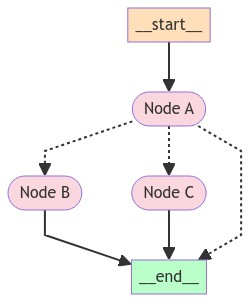

In [68]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [69]:
runnable.invoke([HumanMessage("Hallo")])

Mache etwas mit Nachrichten


[HumanMessage(content='Hallo Welt!', id='da62f34c-94d2-4694-adbe-99319e67b04f')]

In [70]:
runnable.invoke([HumanMessage("Hi")])

Mache etwas mit Nachrichten
Mache etwas mit Nachrichten


[HumanMessage(content='Hi', id='558ec999-b089-4f3a-bd0c-86aea4a7e456')]

Ok soweit so gut... lass uns das etwas aufbohren und eine Zyklus einbauen.

In [71]:
from langgraph.graph import MessageGraph, START, END
from langchain_core.messages import HumanMessage

graph = MessageGraph()

def mache_etwas_mit_nachrichten(input: list[HumanMessage]):
    input.append(HumanMessage("Blabla"))
    return input
 
def pruefe_laenge(input: list[HumanMessage]):
    if len(input) > 5:
        return "Reicht!"
    else:
        return "Komm geht noch weiter!"


graph.add_node("Node A", mache_etwas_mit_nachrichten)

graph.add_edge(START, "Node A")
graph.add_conditional_edges("Node A", pruefe_laenge, { "Reicht!": END, "Komm geht noch weiter!": "Node A" })

runnable = graph.compile()

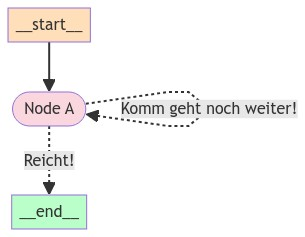

In [72]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [73]:
runnable.invoke([HumanMessage("Hallo")])

[HumanMessage(content='Hallo', id='eb8646d0-db93-42fe-88b2-63d9b1fa7561'),
 HumanMessage(content='Blabla', id='e4e2bcc8-228c-42da-a7b4-e9ee820795cc'),
 HumanMessage(content='Blabla', id='866d82a2-69f1-4407-902b-0afd78b0e48d'),
 HumanMessage(content='Blabla', id='bee9e183-a41d-43cb-976b-b6fc729e864d'),
 HumanMessage(content='Blabla', id='b837499f-2b1b-4fd2-9dac-50e3ba9379b1'),
 HumanMessage(content='Blabla', id='6235fa5f-5ff5-4a0e-b742-37afc626c097')]

Wir haben jetzt die Grundbausteine kennengelernt, also lass uns jetzt etwas sinnvolles machen: lasst uns das Hallo-Welt der KIs bauen: einen Chatbot!

Der Chatbot soll solange Fragen entgegen nehmen und beantworten, bis der Benutzer "exit" eingibt.

In [74]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, AzureChatOpenAI

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")

# model = ChatOpenAI(model="gpt-4o")
model = AzureChatOpenAI(openai_api_version="2024-05-01-preview", azure_deployment="gpt-4o", temperature=0.5)

In [75]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [76]:
def get_user_input(state: State):
    user_input = input("User: ")
    state["messages"].append(HumanMessage(user_input))
    return state

def chatbot(state: State):
    response = model.invoke(state["messages"])
    print("Bot:", response.content)

    state["messages"].append(response)

    return state

def is_end(state: State):
    if(state["messages"][-1].content == "exit"):
        return "end"
    else:
        return "continue"
    

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("get_user_input", get_user_input)

In [77]:
graph_builder.add_edge(START, "get_user_input")
graph_builder.add_conditional_edges("get_user_input", is_end, { "end": END, "continue": "chatbot" })
graph_builder.add_edge("chatbot", "get_user_input")

In [78]:
graph = graph_builder.compile()

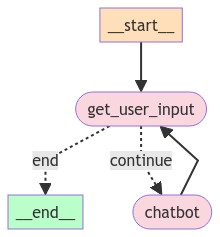

In [79]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [80]:
graph.invoke({"messages": []})

Bot: Hello! How can I assist you today?
Bot: Sure! What kind of story would you like to hear? It could be an adventure, a fairy tale, a mystery, or something else entirely. Let me know!
Bot: Alright, here's a mystery story for you:

---

**The Whispering Shadows**

In the quaint town of Eldridge, nestled between rolling hills and dense forests, there was an old mansion known as Ravenwood Manor. The mansion had stood for centuries, its grand architecture now cloaked in ivy and mystery. The townspeople often spoke in hushed tones about the eerie occurrences that surrounded the manor, but few dared to venture near.

One crisp autumn evening, a young journalist named Clara Bennett arrived in Eldridge. Clara had always been fascinated by unsolved mysteries, and Ravenwood Manor was at the top of her list. Determined to uncover the truth behind the whispers, she decided to spend the night in the mansion.

Armed with a flashlight, a notebook, and a camera, Clara made her way to the manor just 

{'messages': [HumanMessage(content='Hi!', id='6d0f2169-3a79-40fe-81ff-eee7e659f9c2'),
  AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-b9b9a840-90f0-43e0-8b45-eff84757d929-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 

Ok zugegeben, das war eine Menge Code für einen Chatbot!

Aber es zeigt zumindest einigermaßen, wie LangGraph tickt. Wir haben also offensichtlich einen Grafen, wo die Knoten Agentenfunktionen abbilden.